In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
os.getcwd()
os.chdir("/home/mbilkis/OneDrive/digital-brain/RESEARCH/Sindy/")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 
from numba import jit
from integration.integrate import *
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint


In [36]:
device = torch.device("cpu")#""
true_A = torch.tensor([[-2.0]]).to(device)
true_y0 = torch.tensor([[2.]]).to(device)

data_size = 1000
batch_size = 10
batch_time = 20

times = torch.linspace(0,10,data_size)

In [37]:
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y, true_A)

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, times, method='euler')
#plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze())



In [5]:
pred_y = odeint(func, true_y0, times)
plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze())
plt.plot(times.cpu().squeeze(),pred_y.detach().numpy().squeeze())

NameError: name 'func' is not defined

In [38]:
class ODEFunc(nn.Module):

    def __init__(self,latent_dim=1,nhidden=20):
        super(ODEFunc, self).__init__()
        
        self.net = nn.Sequential(
            nn.ELU(inplace=True),
            nn.Linear(latent_dim, nhidden),
            nn.Linear(nhidden, nhidden),
            nn.Linear(nhidden, nhidden),
            nn.Linear(nhidden, latent_dim),)
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=1.)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y ):
        return self.net(y)
    
def get_batch(func,batch_time = 10, batch_size = 20):
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    #batch_y0 = func(s)
    batch_t = times[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

#batch_y0, batch_t, batch_y = get_batch()
#bb = torch.unsqueeze(batch_y0,-1)
#pred_y = odeint(func, batch_y0, batch_t).to(device)
#batch_y0, batch_t, batch_y = get_batch(func)

In [39]:
torch.manual_seed(0)
func = ODEFunc().to(device)
func(batch_t, batch_y).shape

torch.Size([100, 10, 1, 1])

In [40]:
batch_y0, batch_t, batch_y = get_batch(func)
pred_y = odeint(func, batch_y0, batch_t).to(device)

In [48]:
torch.manual_seed(0)
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-2)

history = {}
history["losses"] = []
history["params"] = [k.detach().numpy() for k in list(func.parameters())]
history["gradients"] = []


for itr in tqdm(range(1, 200)):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(func)
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y)/torch.sum(torch.abs(batch_y)))
    loss.backward()
    optimizer.step()

    
    history["losses"].append(loss.item())
    history["params"].append([k.detach().numpy() for k in list(func.parameters())])
    history["gradients"].append([k.grad for k in list(func.parameters())])

    if itr % 10 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, times)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()


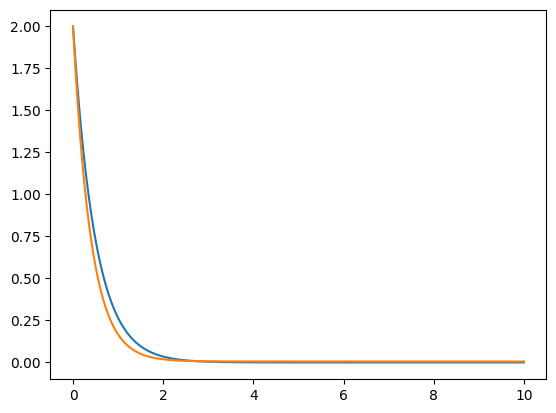

In [45]:
pred_y = odeint(func, true_y0, times)
plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze())
plt.plot(times.cpu().squeeze(),pred_y.detach().numpy().squeeze())

In [154]:
torch.manual_seed(0)
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

for itr in tqdm(range(1, 200)):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr % 10 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            ii += 1

    end = time.time()


In [ ]:
pred_y = odeint(func, true_y0, t)
plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze())
plt.plot(times.cpu().squeeze(),pred_y.detach().numpy().squeeze())

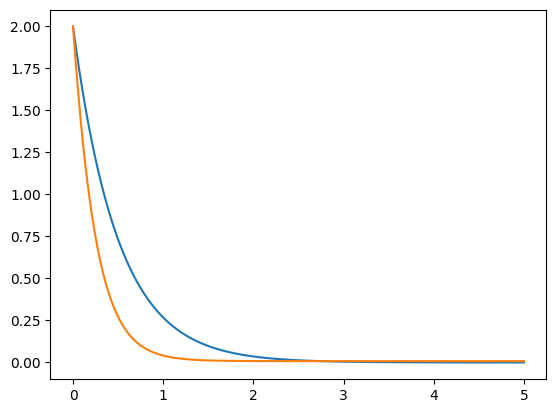

In [162]:
torch.manual_seed(0)

rrn = RecurrentNetwork()

f_true = torch.tensor(data=xx1.T[:,0],dtype=torch.float32).to(torch.device("cpu"))
X_times = torch.tensor(data=times,dtype=torch.float32).to(torch.device("cpu"))

In [150]:
cost(f_true, f_hats)

tensor(0.9983, grad_fn=<DivBackward0>)

In [157]:
def cost(f_true, f_hats):
    return torch.mean( (torch.squeeze(f_hats) - f_true )**2)#/torch.sum(f_true**2)

In [158]:
torch.manual_seed(0)

RNN = RecurrentNetwork()

f_true = torch.tensor(data=xx1.T[:,0],dtype=torch.float32).to(torch.device("cpu"))
X_times = torch.tensor(data=times,dtype=torch.float32).to(torch.device("cpu"))
optimizer = torch.optim.Adam(list(RNN.parameters()), lr=1e-2)
history = {}
history["losses"] = []
history["params"] = [k.detach().numpy() for k in list(RNN.parameters())]
history["gradients"] = []

alpha = 10.
for ind in range(100):
    h_states, f_hats =RNN(X_times)
    loss = cost(f_true, f_hats)#cost(dys, f_dot, f_true, RNN, alpha_0=10., alpha_1 = 10.)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append([k.detach().numpy() for k in list(RNN.parameters())])
    history["gradients"].append([k.grad for k in list(RNN.parameters())])
    if ind%10==0:
        print(ind," ",loss.item())
    
    optimizer.zero_grad()

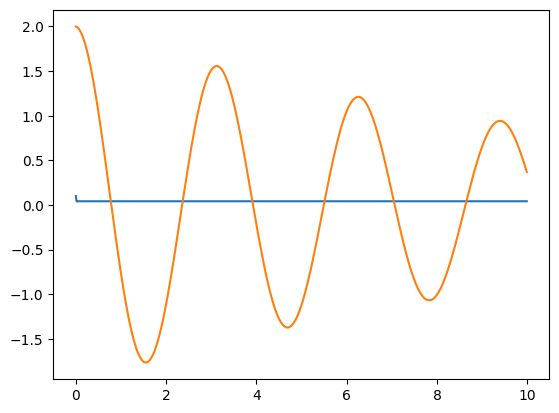

In [160]:
h_states, f_hats =RNN(X_times)
plt.plot(times,f_hats.detach().numpy().squeeze())
plt.plot(times,f_true)#.detach().numpy().squeeze())

In [ ]:

f_dot = np.stack([f(x,t) for x,t in zip(xx1.T,times)])

def lasso_cost_ders(x, f_dot, f_true, model, alpha_0=0.01, alpha_1 = 0.1):
    f_hat, yh, xdoth = model(x)
    return torch.sum((f_true - f_hat)**2) + alpha_1*torch.sum((f_dot - xdoth)**2) +  alpha_0*torch.sum(torch.abs(model.RCell.coeffs_f)) 

oscil = lambda g,o: np.array([[-g,-o],[o,-g]]) 

gi_0, oi_0 = .1, 2.
gi_1, oi_1 = .5, 1.
initial_coeffs = np.concatenate([oscil(gi_0,oi_0),np.zeros((2,2))])#oscil(gi_1,oi_1)])
intial_amplitude = [2.,0.]

initial_params = [intial_amplitude, initial_coeffs]

inputs_cell = [dt, initial_params]#,  [gamma, omega, n, eta, kappa, b], 3*omega]

RNN = RecurrentNetwork(inputs_cell)

dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
f_true = torch.tensor(xx1.T).to(torch.device("cpu"))
f_dot = torch.tensor(np.stack([f(x,t) for x,t in zip(xx1.T[1:],times[1:])])).to(torch.device("cpu"))

alpha = 10.
optimizer = torch.optim.Adam(list(RNN.parameters()), lr=1e-2)
dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
history = {}
history["losses"] = []
history["params"] = [RNN.RCell.coeffs_f.detach().numpy()]
history["gradients"] = []

alpha = 10.
for ind in range(500):
    loss = lasso_cost_ders(dys, f_dot, f_true, RNN, alpha_0=10., alpha_1 = 10.)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append([k.detach().numpy() for k in list(RNN.parameters())])
    history["gradients"].append([k.grad for k in list(RNN.parameters())])
    if ind%10==0:
        print(ind," ",loss.item())
    
    
    print(loss.item())
    
    optimizer.zero_grad()

In [34]:


class GRNN(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(GRNN, self).__init__()
        self.dt = inputs_cell[0]
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b = torch.nn.Parameter(torch.randn(hidden_size))


    def forward(self, dy, state):
        """
        input_data is dy
        hidden_state is x: (<q>, <p>, Var[x], Var[p], Cov(q,q)})
        output dy_hat
        """
        f = state

        #dictionary = torch.concatenate([f, f**3])
        
        #df = self.dt*   #dictionary.matmul(self.coeffs_f) ###Check this!
        fnew = f+ df
        
        return fnew, dy, df/self.dt

    
    self.linear = nn.Linear(hidden_size, 1) 
class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = GRNN(inputs_cell=inputs_cell)
        self.initial_amplitude = torch.nn.Parameter(torch.tensor(data = inputs_cell[1][0], dtype=torch.float32,
                                                   requires_grad=True))
        
    def forward(self, dys):
        dys_hat = []
        xs_hat = [self.initial_amplitude]
        x_hat = xs_hat[0]
        x_dot_hat = []
        for dy_t in dys:
            x_hat, dy_hat, df_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
            x_dot_hat+= [df_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat), torch.stack(x_dot_hat)


In [39]:
def lasso_cost(x,f_true,model,alpha=0.01):
    return torch.sum((f_true - model(x)[0])**2) + alpha*torch.sum(torch.abs(model.RCell.coeffs_f))

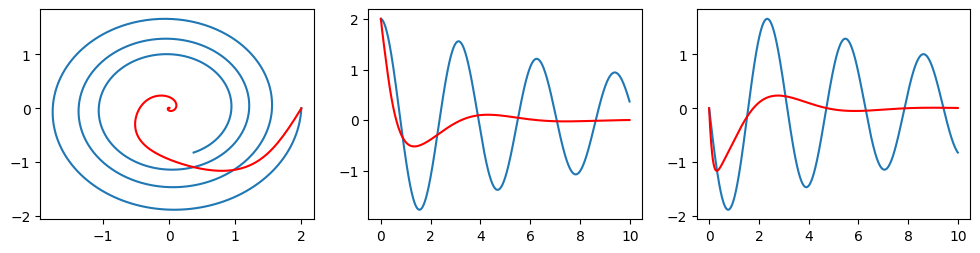

In [88]:
oscil = lambda g,o: np.array([[-g,-o],[o,-g]]) 

gi_0, oi_0 = .5, 1.
gi_1, oi_1 = .5, 1.
initial_coeffs = np.concatenate([oscil(gi_0,oi_0),oscil(gi_1,oi_1)])
intial_amplitude = [2.,0.]

initial_params = [intial_amplitude, initial_coeffs]

inputs_cell = [dt, initial_params]#,  [gamma, omega, n, eta, kappa, b], 3*omega]

RNN = RecurrentNetwork(inputs_cell)

dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
f_true = torch.tensor(xx1.T).to(torch.device("cpu"))

f_hat, dys_hat = RNN(dys)
f_hat = f_hat.detach().numpy()

plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1[0,:], xx1[1,:])
ax.plot(f_hat[:,0], f_hat[:,1], color="red")

ax = plt.subplot(232)
ax.plot(times, xx1[0,:])
ax.plot(times, f_hat[:,0], color="red")

ax = plt.subplot(233)
ax.plot(times, xx1[1,:])
ax.plot(times, f_hat[:,1], color="red")


In [94]:
optimizer = torch.optim.Adam(list(RNN.parameters()), lr=1e-2)
dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
history = {}
history["losses"] = []
history["params"] = [k.detach().numpy() for k in list(RNN.parameters())]
history["gradients"] = []

alpha = 10.
for ind in range(200):
    loss = lasso_cost(dys, f_true,RNN, alpha=alpha)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append([k.detach().numpy() for k in list(RNN.parameters())])
    history["gradients"].append([k.grad for k in list(RNN.parameters())])
    if ind%10==0:
        print(ind," ",loss.item())
    
    optimizer.zero_grad()

0   1627.4810736349662
10   1544.187369210905
20   1455.4062113605792
30   1313.8546409996104
40   892.9812179523773
50   313.4288852911827
60   130.6861734486849
70   154.34055814759566
80   126.40313701289497
90   124.48196943114664
100   119.21260206079288
110   117.30299495601764
120   115.99120229653855
130   115.07432353315393
140   114.16089025106427
150   113.2086837583066
160   112.15644045607115
170   111.01228354873143
180   109.75551211938509
190   108.37040310791993


In [96]:
for ind in range(200):
    loss = lasso_cost(dys, f_true,RNN, alpha=alpha)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append([k.detach().numpy() for k in list(RNN.parameters())])
    history["gradients"].append([k.grad for k in list(RNN.parameters())])
    if ind%10==0:
        print(ind," ",loss.item())
    
    optimizer.zero_grad()

0   106.83531183047651
10   105.12483732958172
20   103.20840660976843
30   101.04905103295224
40   98.60244891646758
50   95.81517872583218
60   92.6266180882884
70   88.97169192754207
80   84.79337670259781
90   80.2207698648512
100   75.48469416584867
110   70.55857478896593
120   66.03966361857168
130   62.97068879557767
140   60.57096612364384
150   58.62645833337885
160   56.95474074888155
170   55.45417325259045
180   54.09274382584499
190   52.86216991242256


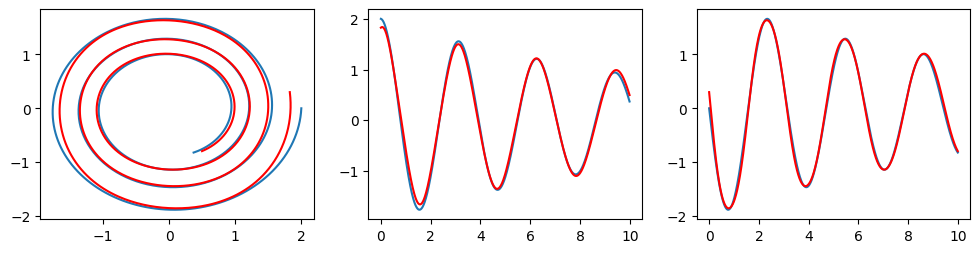

In [103]:
f_hat, dys_hat = RNN(dys)
f_hat = f_hat.detach().numpy()

plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1[0,:], xx1[1,:])
ax.plot(f_hat[:,0], f_hat[:,1], color="red")

ax = plt.subplot(232)
ax.plot(times, xx1[0,:])
ax.plot(times, f_hat[:,0], color="red")

ax = plt.subplot(233)
ax.plot(times, xx1[1,:])
ax.plot(times, f_hat[:,1], color="red")


Text(0.5, 1.0, 'alpha = 10.0')

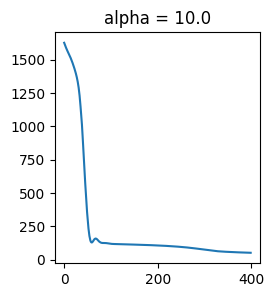

In [104]:
plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax.set_title("alpha = {}".format(alpha))

In [102]:
params_evol[-1]

[array([1.407255  , 0.30905733], dtype=float32),
 array([[ 0.01425135, -1.1806448 ],
        [ 1.1575674 ,  0.08404221],
        [-0.00621379, -0.6448919 ],
        [ 0.56090266, -0.10936841]], dtype=float32)]

In [99]:
amplitudes = np.stack([params_evol[k][0]for k in range(len(params_evol))])
coeffs = np.stack([params_evol[k][1]for k in range(len(params_evol))])

ValueError: all input arrays must have the same shape

In [75]:
for ind in range(200):
    loss = lasso_cost(dys, f_true,RNN, alpha=alpha)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append([k.detach().numpy() for k in list(RNN.parameters())])
    history["gradients"].append([k.grad for k in list(RNN.parameters())])
    if ind%10==0:
        print(ind," ",loss.item())
    
    optimizer.zero_grad()

0   126.2355630123988
10   125.905087766119
20   125.07098305103757
30   124.98126668607117
40   124.74185852743311
50   124.51186749706653
60   124.43473213223643
70   129.95883791988095
80   126.17763919731325
90   124.39297542815632
100   123.68217752381263
110   123.448028925109
120   123.24408657520866
130   123.00115701764798
140   122.76702498380983
150   122.55487888641305
160   122.66431491112596
170   127.3765281464422
180   124.34310150428432
190   122.39616118631012


In [80]:
params_evol = history["params"]

In [87]:
params_evol[2]

[array([1.407255  , 0.30905733], dtype=float32),
 array([[ 0.01425135, -1.1806448 ],
        [ 1.1575674 ,  0.08404221],
        [-0.00621379, -0.6448919 ],
        [ 0.56090266, -0.10936841]], dtype=float32)]

In [84]:
amplitudes = np.stack([params_evol[k][0]for k in range(len(params_evol))])
coeffs = np.stack([params_evol[k][1]for k in range(len(params_evol))])

ValueError: all input arrays must have the same shape

In [78]:
params_evol = np.stack(history["params"])

/home/mbilkis/.local/lib/python3.10/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


ValueError: all input arrays must have the same shape

In [131]:
params_evol = np.stack(history["params"])
print(params_evol[0,:,:])
print(params_evol[-1,:,:])

array([[-1.0073173e-01, -1.8302536e+00],
       [ 2.1763725e+00, -9.9489436e-02],
       [ 7.8547723e-04, -7.5506426e-02],
       [-8.1949241e-02, -5.5627488e-06]], dtype=float32)

In [130]:
params_evol[0,:,:]

array([[-1.0073173e-01, -1.8302536e+00],
       [ 2.1763725e+00, -9.9489436e-02],
       [ 7.8547723e-04, -7.5506426e-02],
       [-8.1949241e-02, -5.5627488e-06]], dtype=float32)

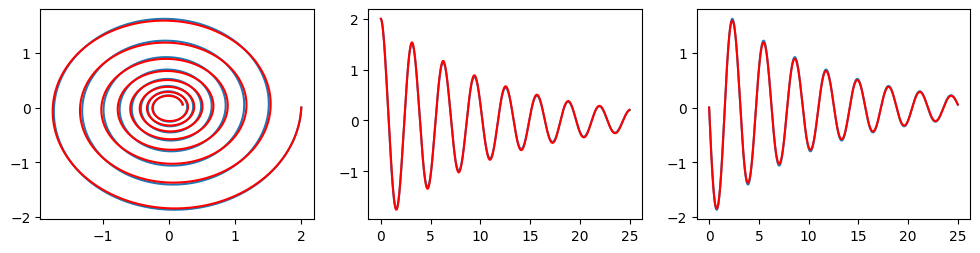

In [141]:
plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1[0,:], xx1[1,:])
ax.plot(f_hat[:,0], f_hat[:,1], color="red")

ax = plt.subplot(232)
ax.plot(times, xx1[0,:])
ax.plot(times, f_hat[:,0], color="red")

ax = plt.subplot(233)
ax.plot(times, xx1[1,:])
ax.plot(times, f_hat[:,1], color="red")

plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax.set_title("alpha = {}".format(alpha))

### optimization a bit more difficult, having all parameters initialized differently

In [156]:
omega_f,gamma_f = 2., .1
initial_params = [ [-2*gamma_f,-2*omega_f], [2*omega_f, -2*gamma_f], [-2*gamma_f,-2*omega_f], [2*omega_f, -2*gamma_f] ]

inputs_cell = [dt, initial_params]#,  [gamma, omega, n, eta, kappa, b], 3*omega]

RNN = RecurrentNetwork(inputs_cell)

alpha = 10.
optimizer = torch.optim.Adam(list(RNN.parameters()), lr=1e-2)
dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
history = {}
history["losses"] = []
history["params"] = [RNN.RCell.coeffs_f.detach().numpy()]
history["gradients"] = []

alpha = 10.
for ind in range(500):
    loss = lasso_cost(dys, f_true,RNN, alpha=alpha)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(RNN.RCell.coeffs_f.detach().numpy())
    history["gradients"].append(RNN.RCell.coeffs_f.grad.numpy())
    
    print(loss.item())
    
    optimizer.zero_grad()

6492.0791015625
6292.32470703125
6135.39111328125
6009.22998046875
5906.435546875
5819.85498046875
5746.06689453125
5682.83935546875
5628.11669921875
5580.20556640625
5537.86572265625
5500.19677734375
5466.50537109375
5436.224609375
5408.87744140625
5384.0625
5361.43994140625
5340.7265625
5321.69189453125
5304.1416015625
5287.9140625
5272.87353515625
5258.90576171875
5245.9091796875
5233.7958984375
5222.49072265625
5211.92041015625
5202.02294921875
5192.7412109375
5184.01953125
5175.81298828125
5168.07373046875
5160.76318359375
5153.84228515625
5147.27734375
5141.0361328125
5135.08984375
5129.41064453125
5123.9755859375
5118.7607421875
5113.748046875
5108.91796875
5104.2529296875
5099.73828125
5095.35986328125
5091.10302734375
5086.9599609375
5082.9169921875
5078.96533203125
5075.09619140625
5071.3017578125
5067.57470703125
5063.90869140625
5060.296875
5056.73583984375
5053.21875
5049.74169921875
5046.30078125
5042.89306640625
5039.5146484375
5036.16357421875
5032.83642578125
5029.5322

In [157]:
params_evol = np.stack(history["params"])
print(params_evol[0,:,:])
print("\n")
print(params_evol[-1,:,:])

[[ 0.16063935 -1.1341791 ]
 [ 1.0799567   0.15946116]
 [-0.83252054 -4.110235  ]
 [ 4.090174   -0.79979897]]


[[ 0.16063935 -1.1341791 ]
 [ 1.0799567   0.15946116]
 [-0.83252054 -4.110235  ]
 [ 4.090174   -0.79979897]]


Text(0.5, 1.0, 'alpha = 10.0')

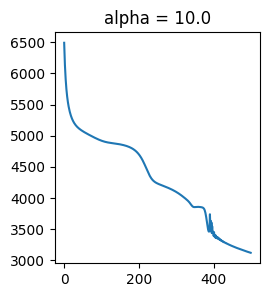

In [158]:
plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax.set_title("alpha = {}".format(alpha))

In [110]:
RNN.

array([[-0.2       , -4.        ],
       [-0.2798    , -3.992     ],
       [-0.3593602 , -3.982412  ],
       ...,
       [-1.65191339, -0.72406946],
       [-1.66474287, -0.69030712],
       [-1.67688427, -0.65632196]])

## Learning derivative as well!

74.09427499177545
1914.628663825183
250.27578681843323
766.1197523029086
817.2385655286146
186.51442940747728
155.46313054952242
433.01039283704716
549.9866965368226
385.08365735479526
129.30092467081278
61.50475938901616
236.08736508452273
338.88387497137785
208.52301275772513
66.4637790182675
73.28241025865101
166.9204835455883
216.37236295492212
169.41184722560334
81.30266815521986
47.21783296680741
96.1245530629644
146.75781641561042
122.22173712915173
63.63240493120654
48.33062588750077
79.98632903316738
106.50068910137526
94.54698774216463
61.42442773819825
47.241435397466994
64.68326865740269
82.90671957785533
73.449308262458
52.144950782887406
48.498204286647166
61.47536729019731
68.83850246688712
60.73520714751072
49.1407236272734
48.85964892955905
57.23927854176405
59.46127088168923
52.12933619885465
46.89532798342492
49.993901086501054
54.39112119997745
52.85274868079981
47.97635976027836
46.75534842258516
49.81429331120188
51.11780472226933
48.30881273716662
46.051834094508

42.77913707894282
42.77914270217532
42.77913914232553
42.77913404173171
42.77914115241995
42.779136575721495
42.77913031877847
42.77912728939987
42.77913062018611
42.779137632830434
42.779129511068405
42.77913264813329
42.77913806660995
42.779125228660696
42.779125341891685
42.77912895601554
42.779134510982985
42.77913026212522
42.77913489031146
42.77911864472708
42.77911945771468
42.77912484560292
42.77913084178122
42.779127014297494
42.77912359064282
42.77912551798596
42.77912578170158
42.7791166382345
42.77912694545796
42.77912626067175
42.77912481466911
42.77912672420415
42.77912508975307
42.77913004167113
42.77911877130777
42.77911926024983
42.77912234674788
42.77913297811315
42.77911576054382
42.77911845647494
42.77911138349159
42.77912439783253
42.779122540943796
42.7791220759454
42.77910933363827
42.77912394319443
42.779115635215796
42.77911796732285
42.779121895770785
42.77911152881853


In [187]:
f_hat, yh, xdoth = RNN(dys)
f_hat = f_hat.detach().numpy()

Text(0.5, 1.0, 'alpha = 10.0')

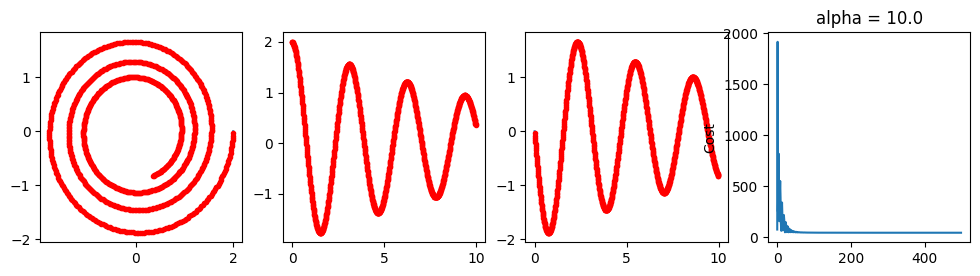

In [197]:
plt.figure(figsize=(12,6))
ax = plt.subplot(241)
ax.plot(xx1[0,:], xx1[1,:])
ax.plot(f_hat[:,0], f_hat[:,1], color="red",marker='.')

ax = plt.subplot(242)
ax.plot(times, xx1[0,:])
ax.plot(times, f_hat[:,0], color="red",marker='.')

ax = plt.subplot(243)
ax.plot(times, xx1[1,:])
ax.plot(times, f_hat[:,1], color="red",marker='.')

ax=plt.subplot(244)
ax.plot(history["losses"])
ax.set_ylabel("Cost")
ax.set_title("alpha = {}".format(alpha))

In [199]:
oscil = lambda g,o: np.array([[-g,-o],[o,-g]]) 

gi_0, oi_0 = .1, 2.
gi_1, oi_1 = .5, 1.
initial_coeffs = np.concatenate([oscil(gi_0,oi_0),oscil(gi_0,oi_0)])#oscil(gi_1,oi_1)])
intial_amplitude = [2.,0.]

initial_params = [intial_amplitude, initial_coeffs]

inputs_cell = [dt, initial_params]#,  [gamma, omega, n, eta, kappa, b], 3*omega]

RNN = RecurrentNetwork(inputs_cell)

dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
f_true = torch.tensor(xx1.T).to(torch.device("cpu"))
f_dot = torch.tensor(np.stack([f(x,t) for x,t in zip(xx1.T[1:],times[1:])])).to(torch.device("cpu"))


optimizer = torch.optim.Adam(list(RNN.parameters()), lr=1e-2)
dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
history = {}
history["losses"] = []
history["params"] = [RNN.RCell.coeffs_f.detach().numpy()]
history["gradients"] = []

for ind in range(500):
    loss = lasso_cost_ders(dys, f_dot, f_true, RNN, alpha_0=10., alpha_1 = 10.)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(RNN.RCell.coeffs_f.detach().numpy())
    history["gradients"].append(RNN.RCell.coeffs_f.grad.numpy())
    if ind%10==0:
        print(loss.item())
    
    optimizer.zero_grad()

689370.0158680407
214852.109021225
177372.42911040364
175860.92869913668
169332.55921880828
161193.8659811835
153842.31938692436
149805.80433983088
146488.67251365865
143007.53846784926
139831.54077721233
136792.14478781758
133881.91868126686
131101.9317884476
128430.2572992778
125856.0598051732
123368.6454550023
120956.91435524389
118610.35103593985
116318.93219994516
114073.33934261583
111865.2228362978
109686.88311815319
107530.96001232123
105390.26108581081
103257.19760995409
101123.25023557711
98978.28639041737
96809.43420499592
94599.58507544886
92324.67843846136
89949.32632391168
87419.19391447437
84648.60464355779
81504.87118969149
77804.21747680311
73377.25482017154
68305.2259944309
63238.529490353445
59166.59126564425
56494.599294327774
54814.29082349886
53630.95594005117
52711.91709817704
51911.652887836724
51128.29079532839
50313.69650670748
49434.69374910823
48468.92967272461
47397.14677087894


In [202]:
for ind in range(500):
    loss = lasso_cost_ders(dys, f_dot, f_true, RNN, alpha_0=10., alpha_1 = 10.)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(RNN.RCell.coeffs_f.detach().numpy())
    history["gradients"].append(RNN.RCell.coeffs_f.grad.numpy())
    if ind%10==0:
        print(loss.item())
    
    optimizer.zero_grad()

3734.8399901850926
3718.534296875642
3702.1649624430333
3685.7202688418424
3669.2020533643395
3652.6151174447336
3635.9499325827155
3619.2226143169546
3602.411197510277
3585.5343406454404
3568.5739602571775
3551.5361232865343
3534.4236850851184
3517.231958924203
3499.968587950191
3482.6212992356586
3465.1983163925916
3447.6934304504207
3430.1078975536952
3412.442967119559
3394.6883334199615
3376.8561137010433
3358.940788694674
3340.9366666158007
3322.849145459729
3304.6750423307426
3286.413363014463
3268.059561454202
3249.618729211716
3231.0879247356033
3212.4612391348546
3193.7423757507036
3174.9317279827824
3156.021126960166
3137.0166868311753
3117.908986663934
3098.7010593545883
3079.394467008889
3059.9783921209696
3040.4623339424397
3020.8359273723095
3001.094415501541
2981.2489148982136
2961.2878001070185
2941.202459187443
2921.0034945881966
2900.68514795872
2880.2391953687084
2859.6651720473437
2838.9650680344766


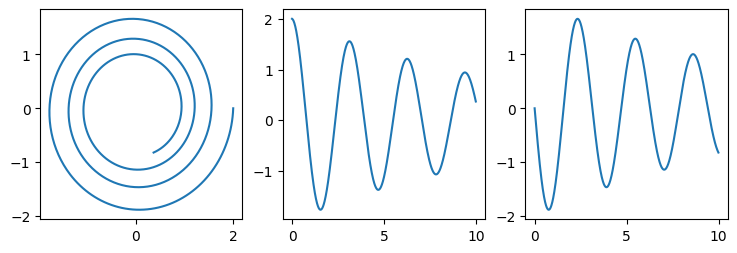

In [235]:
f_hat, yh, xdoth = RNN(dys)
f_hat = f_hat.detach().numpy()
plt.figure(figsize=(12,6))
ax = plt.subplot(241)
ax.plot(xx1[0,:], xx1[1,:])
#ax.plot(f_hat[:,0], f_hat[:,1], color="red",marker='.')

ax = plt.subplot(242)
ax.plot(times, xx1[0,:])
#ax.plot(times, f_hat[:,0], color="red",marker='.')

ax = plt.subplot(243)
ax.plot(times, xx1[1,:])
#ax.plot(times, f_hat[:,1], color="red",marker='.')



FIx the amplitude

In [254]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


class GRNN(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(GRNN, self).__init__()
        self.dt = inputs_cell[0]
        initial_data_f = inputs_cell[1][1]
        self.coeffs_f = torch.nn.Parameter(data = torch.tensor(initial_data_f, dtype=torch.float32,
                                                                      requires_grad = True))
        
    def forward(self, dy, state):
        """
        input_data is dy
        hidden_state is x: (<q>, <p>, Var[x], Var[p], Cov(q,q)})
        output dy_hat
        """
        f = state

        dictionary = torch.concatenate([f, f**3])
        
        df = self.dt*dictionary.matmul(self.coeffs_f) ###Check this!
        fnew = f+ df
        
        return fnew, dy, df/self.dt

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = GRNN(inputs_cell=inputs_cell)
        self.initial_amplitude = torch.nn.Parameter(torch.tensor(data = inputs_cell[1][0], dtype=torch.float32,
                                                   requires_grad=True))
        
    def forward(self, dys):
        dys_hat = []
        xs_hat = [self.initial_amplitude]
        x_hat = xs_hat[0]
        x_dot_hat = []
        for dy_t in dys:
            x_hat, dy_hat, df_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
            x_dot_hat+= [df_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat), torch.stack(x_dot_hat)

In [255]:
def cost(x, f_dot, f_true, model, alpha_1=0.01, alpha_2 = 0.1):
    f_hat, yh, xdoth = model(x)
    l0=torch.sum((f_true - f_hat)**2)/times[-1]
    l1 = alpha_1*torch.sum(torch.abs(model.RCell.coeffs_f)) 
    l2=alpha_2*torch.sum((f_dot - xdoth)**2)/times[-1]
    return l0+l1+l2, torch.stack([l0,alpha_1*l1,alpha_2*l2])

In [257]:
torch.manual_seed(0)

oscil = lambda g,o: np.array([[-g,-o],[o,-g]]) 

gi_0, oi_0 = .1, 2.
gi_1, oi_1 = .5, 1.
initial_coeffs = np.concatenate([oscil(gi_0,oi_0),oscil(gi_0,oi_0)])#oscil(gi_1,oi_1)])
intial_amplitude = [1.,0.]

initial_params = [intial_amplitude, initial_coeffs]

inputs_cell = [dt, initial_params]#,  [gamma, omega, n, eta, kappa, b], 3*omega]

RNN = RecurrentNetwork(inputs_cell)

dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
f_true = torch.tensor(xx1.T).to(torch.device("cpu"))
f_dot = torch.tensor(np.stack([f(x,t) for x,t in zip(xx1.T[1:],times[1:])])).to(torch.device("cpu"))


optimizer = torch.optim.Adam(list(RNN.parameters()), lr=1e-2)
dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
history = {}
history["losses"] = []
history["params"] = [RNN.RCell.coeffs_f.detach().numpy()]
history["gradients"] = []

for ind in range(5000):
    loss,losses = cost(dys, f_dot, f_true, RNN, alpha_1=5., alpha_2 = 0.0)
    loss.backward()
    
    optimizer.step()
    history["losses"].append([loss.item(), losses.detach().numpy()])
    history["params"].append(RNN.RCell.coeffs_f.detach().numpy())
    history["gradients"].append(RNN.RCell.coeffs_f.grad.numpy())
    if ind%10==0:
     
    optimizer.zero_grad()

[234.6992691 210.          0.       ]
[223.34230365 212.11386108   0.        ]
[220.25135687 214.54267883   0.        ]
[217.59641982 216.66165161   0.        ]
[214.99618424 218.306427     0.        ]
[212.38270119 219.37619019   0.        ]
[209.52050788 219.83340454   0.        ]
[206.12787417 219.69047546   0.        ]
[202.04904355 218.96810913   0.        ]
[197.35790047 217.83706665   0.        ]
[192.54652236 216.70808411   0.        ]
[188.24206338 214.9621582    0.        ]
[184.89339886 213.05200195   0.        ]
[182.578202   211.12089539   0.        ]
[182.23927652 209.23095703   0.        ]
[180.25790477 207.48153687   0.        ]
[179.37537386 205.96325684   0.        ]
[178.5469255 204.5328064   0.       ]
[177.6921984  203.17689514   0.        ]
[176.82055766 201.90361023   0.        ]
[175.91042135 200.71647644   0.        ]
[174.91707156 199.61183167   0.        ]
[173.84105352 198.57582092   0.        ]
[172.66733103 197.58833313   0.        ]
[171.38935808 196.6261

[ 64.88508615 207.22160339   0.        ]
[ 64.82391411 207.25440979   0.        ]
[ 64.76862093 207.2701416    0.        ]
[ 64.7192134  207.26412964   0.        ]
[ 64.6711405  207.25744629   0.        ]
[ 64.62849441 207.23066711   0.        ]
[ 64.58753346 207.20007324   0.        ]
[ 64.54680546 207.1663208    0.        ]
[ 64.50826763 207.12084961   0.        ]
[ 64.46792823 207.0900116    0.        ]
[ 64.43331518 207.02212524   0.        ]
[ 64.40000369 206.95022583   0.        ]
[ 64.36576608 206.89456177   0.        ]
[ 64.32939213 206.83514404   0.        ]
[ 64.29432505 206.77990723   0.        ]
[ 64.25985792 206.71546936   0.        ]
[ 64.22698036 206.64474487   0.        ]
[ 64.1928962  206.58139038   0.        ]
[ 64.15902201 206.51577759   0.        ]
[ 64.12442608 206.45507812   0.        ]
[ 64.09030746 206.39285278   0.        ]
[ 64.05578575 206.33598328   0.        ]
[ 64.01948296 206.29064941   0.        ]
[ 63.98655869 206.21838379   0.        ]
[ 63.95399662 20

KeyboardInterrupt: 

In [261]:
history["params"][-1]

array([[ 4.6309432e-01,  6.7762687e-04],
       [-3.8357527e-04,  1.7086400e+00],
       [-2.7457723e-01, -2.0390763e+00],
       [ 1.9206492e+00, -1.7787845e+00]], dtype=float32)

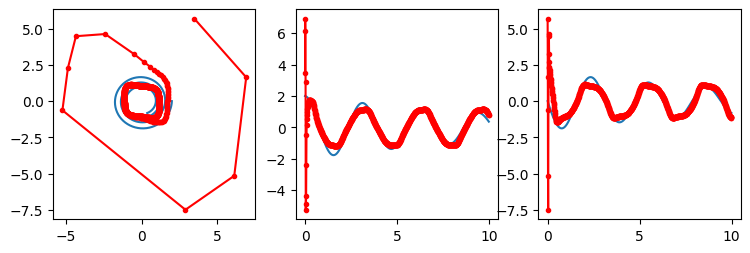

In [260]:
f_hat, yh, xdoth = RNN(dys)
f_hat = f_hat.detach().numpy()
plt.figure(figsize=(12,6))
ax = plt.subplot(241)
ax.plot(xx1[0,:], xx1[1,:])
ax.plot(f_hat[:,0], f_hat[:,1], color="red",marker='.')

ax = plt.subplot(242)
ax.plot(times, xx1[0,:])
ax.plot(times, f_hat[:,0], color="red",marker='.')

ax = plt.subplot(243)
ax.plot(times, xx1[1,:])
ax.plot(times, f_hat[:,1], color="red",marker='.')

#ax=plt.subplot(244)
#ax.plot(history["losses"])
#ax.set_ylabel("Cost")
#ax.set_title("alpha = {}".format(alpha))

Test lasso_ders_model_ f_dot hat

In [ ]:
xh, yh, xdoth = RNN(dys)
f_dot = np.stack([f(x,t) for x,t in zip(xx1.T,times)])
plt.plot(xdoth.detach().numpy()[:,0],'*')
plt.plot(f_dot[:,0],'.')